In [137]:
import pandas as pd
import matplotlib.pyplot as plt

# load dataset into Pandas DataFrame
df = pd.read_csv("log.csv")
df.columns= ['timestamp','latency','gateway']
df = df.set_index('timestamp')
df = df.sort_index(axis=1)
df.head()


,gateway,latency
timestamp,,
01/21/19 02:32 PM,10.138.25.67,0.339817
01/21/19 02:33 PM,10.138.25.67,0.024861
01/21/19 02:34 PM,10.138.25.67,0.022789
01/21/19 02:35 PM,10.138.25.67,0.022000
01/21/19 02:36 PM,10.138.25.67,0.025834


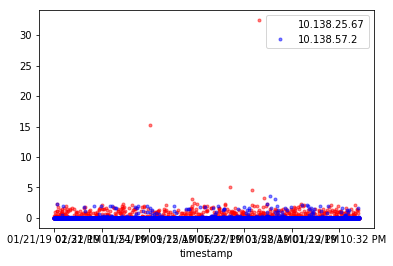

0.026701


In [148]:
fig, ax = plt.subplots()

colors = {'10.138.25.67':'red', '10.138.57.2':'blue'}

grouped = df.groupby('gateway')
for key, group in grouped:
    group.plot(ax=ax, style='.k',  y='latency', label=key, color=colors[key],alpha=0.5)

#plt.ylim(0,5)
plt.show()

print(df['latency'].quantile(0.9))



In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import os


INPUT_DIR = os.path.join( os.getcwd(), "logs")
data = pd.DataFrame()
dirs = [f for f in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR))]    
#print(dirs)
data = {}
for client in dirs:
    files = [f for f in os.listdir(INPUT_DIR+"/"+client) if os.path.isdir(os.path.join(INPUT_DIR,client))]
    client_data = pd.DataFrame()
    for file in files:
        temp =  pd.read_csv(os.path.join(INPUT_DIR, client,file), sep=',')
        temp.columns= ['timestamp','ttfb','latency','gateway','status']
        client_data = pd.concat([client_data,temp])
    client_data = client_data.set_index(pd.DatetimeIndex(client_data['timestamp']))
    client_data.index = client_data.index.map(lambda x: x.replace(second=0, microsecond=0))
    data[client] = client_data


In [188]:
def get_min_date():
    min_date = None
    for d in data:
        c = data.get(d)
        if min_date is None or min_date > c.index.min():
            min_date = c.index.min()
    return min_date#.strftime("%m/%d/%Y, %H:%M:%S")

def get_max_date():
    max_date = None
    for d in data:
        c = data.get(d)
        if max_date is None or max_date > c.index.max():
            max_date = c.index.max()
    return max_date

def get_90th_percentile():
    df = pd.DataFrame()
    for d in data:
        df = pd.concat([df,data.get(d)])
        
    print(df.describe())
    print(df['latency'].max())
    print(df['latency'].min())
    print(df['latency'].mean())
    return df['latency'].quantile(0.9)

def send_info(ts):
    min_date = None
    max_date = None
    
    gateway_table = pd.DataFrame()
    for d in data:
        c = data.get(d)[ts]
        if len(c)>2:
            gateway_table = pd.concat([gateway_table , c.sample(n=2)])
        elif len(c)>0:
            print(c)
            #gateway_table = pd.concat([gateway_table, c])
    #print(gateway_table[['timestamp','gateway','latency']])
        
        
        
        

In [174]:
import datetime

min_date = get_min_date() 
max_date = get_max_date() 

start = min_date

gateway_table = pd.DataFrame()

while(start < max_date):
    send_info(start.strftime("%m/%d/%Y, %H:%M:%S"))
    start = start+datetime.timedelta(minutes=2)
    print(start)
    #break

2019-01-21 14:34:00
2019-01-21 14:36:00
2019-01-21 14:38:00
2019-01-21 14:40:00
2019-01-21 14:42:00
2019-01-21 14:44:00
2019-01-21 14:46:00
2019-01-21 14:48:00
2019-01-21 14:50:00
2019-01-21 14:52:00
2019-01-21 14:54:00
2019-01-21 14:56:00
2019-01-21 14:58:00
2019-01-21 15:00:00
2019-01-21 15:02:00
2019-01-21 15:04:00
2019-01-21 15:06:00
2019-01-21 15:08:00
2019-01-21 15:10:00
2019-01-21 15:12:00
2019-01-21 15:14:00
2019-01-21 15:16:00
2019-01-21 15:18:00
2019-01-21 15:20:00
2019-01-21 15:22:00
2019-01-21 15:24:00
2019-01-21 15:26:00
2019-01-21 15:28:00
2019-01-21 15:30:00
2019-01-21 15:32:00
2019-01-21 15:34:00
2019-01-21 15:36:00
2019-01-21 15:38:00
2019-01-21 15:40:00
2019-01-21 15:42:00
2019-01-21 15:44:00
2019-01-21 15:46:00
2019-01-21 15:48:00
2019-01-21 15:50:00
2019-01-21 15:52:00
2019-01-21 15:54:00
2019-01-21 15:56:00
2019-01-21 15:58:00
2019-01-21 16:00:00
2019-01-21 16:02:00
2019-01-21 16:04:00
2019-01-21 16:06:00
2019-01-21 16:08:00
2019-01-21 16:10:00
2019-01-21 16:12:00


2019-01-22 04:44:00
2019-01-22 04:46:00
2019-01-22 04:48:00
2019-01-22 04:50:00
2019-01-22 04:52:00
2019-01-22 04:54:00
2019-01-22 04:56:00
2019-01-22 04:58:00
2019-01-22 05:00:00
2019-01-22 05:02:00
2019-01-22 05:04:00
2019-01-22 05:06:00
2019-01-22 05:08:00
2019-01-22 05:10:00
2019-01-22 05:12:00
2019-01-22 05:14:00
2019-01-22 05:16:00
2019-01-22 05:18:00
2019-01-22 05:20:00
2019-01-22 05:22:00
2019-01-22 05:24:00
2019-01-22 05:26:00
2019-01-22 05:28:00
2019-01-22 05:30:00
2019-01-22 05:32:00
2019-01-22 05:34:00
2019-01-22 05:36:00
2019-01-22 05:38:00
2019-01-22 05:40:00
2019-01-22 05:42:00
2019-01-22 05:44:00
2019-01-22 05:46:00
2019-01-22 05:48:00
2019-01-22 05:50:00
2019-01-22 05:52:00
2019-01-22 05:54:00
2019-01-22 05:56:00
2019-01-22 05:58:00
2019-01-22 06:00:00
2019-01-22 06:02:00
2019-01-22 06:04:00
2019-01-22 06:06:00
2019-01-22 06:08:00
2019-01-22 06:10:00
2019-01-22 06:12:00
2019-01-22 06:14:00
2019-01-22 06:16:00
2019-01-22 06:18:00
2019-01-22 06:20:00
2019-01-22 06:22:00


2019-01-22 18:36:00
2019-01-22 18:38:00
2019-01-22 18:40:00
2019-01-22 18:42:00
2019-01-22 18:44:00
2019-01-22 18:46:00
2019-01-22 18:48:00
2019-01-22 18:50:00
2019-01-22 18:52:00
2019-01-22 18:54:00
2019-01-22 18:56:00
2019-01-22 18:58:00
2019-01-22 19:00:00
2019-01-22 19:02:00
2019-01-22 19:04:00
2019-01-22 19:06:00
2019-01-22 19:08:00
2019-01-22 19:10:00
2019-01-22 19:12:00
2019-01-22 19:14:00
2019-01-22 19:16:00
2019-01-22 19:18:00
2019-01-22 19:20:00
2019-01-22 19:22:00
2019-01-22 19:24:00
2019-01-22 19:26:00
2019-01-22 19:28:00
2019-01-22 19:30:00
2019-01-22 19:32:00
2019-01-22 19:34:00
2019-01-22 19:36:00
2019-01-22 19:38:00
2019-01-22 19:40:00
2019-01-22 19:42:00
2019-01-22 19:44:00
2019-01-22 19:46:00
2019-01-22 19:48:00
2019-01-22 19:50:00
2019-01-22 19:52:00
2019-01-22 19:54:00
2019-01-22 19:56:00
2019-01-22 19:58:00
2019-01-22 20:00:00
2019-01-22 20:02:00
2019-01-22 20:04:00
2019-01-22 20:06:00
2019-01-22 20:08:00
2019-01-22 20:10:00
2019-01-22 20:12:00
2019-01-22 20:14:00


2019-01-23 07:14:00
2019-01-23 07:16:00
2019-01-23 07:18:00
2019-01-23 07:20:00
2019-01-23 07:22:00
2019-01-23 07:24:00
2019-01-23 07:26:00
2019-01-23 07:28:00
2019-01-23 07:30:00
2019-01-23 07:32:00
2019-01-23 07:34:00
2019-01-23 07:36:00
2019-01-23 07:38:00
2019-01-23 07:40:00
2019-01-23 07:42:00
2019-01-23 07:44:00
2019-01-23 07:46:00
2019-01-23 07:48:00
2019-01-23 07:50:00
2019-01-23 07:52:00
2019-01-23 07:54:00
2019-01-23 07:56:00
2019-01-23 07:58:00
2019-01-23 08:00:00
2019-01-23 08:02:00
2019-01-23 08:04:00
2019-01-23 08:06:00
2019-01-23 08:08:00
2019-01-23 08:10:00
2019-01-23 08:12:00
2019-01-23 08:14:00
2019-01-23 08:16:00
2019-01-23 08:18:00
2019-01-23 08:20:00
2019-01-23 08:22:00
2019-01-23 08:24:00
2019-01-23 08:26:00
2019-01-23 08:28:00
2019-01-23 08:30:00
2019-01-23 08:32:00
2019-01-23 08:34:00
2019-01-23 08:36:00
2019-01-23 08:38:00
2019-01-23 08:40:00
2019-01-23 08:42:00
2019-01-23 08:44:00
2019-01-23 08:46:00
2019-01-23 08:48:00
2019-01-23 08:50:00
2019-01-23 08:52:00


2019-01-23 20:54:00
2019-01-23 20:56:00
2019-01-23 20:58:00
2019-01-23 21:00:00
2019-01-23 21:02:00
2019-01-23 21:04:00
2019-01-23 21:06:00
2019-01-23 21:08:00
2019-01-23 21:10:00
2019-01-23 21:12:00
2019-01-23 21:14:00
2019-01-23 21:16:00
2019-01-23 21:18:00
2019-01-23 21:20:00
2019-01-23 21:22:00
2019-01-23 21:24:00
2019-01-23 21:26:00
2019-01-23 21:28:00
2019-01-23 21:30:00
2019-01-23 21:32:00
2019-01-23 21:34:00
2019-01-23 21:36:00
2019-01-23 21:38:00
2019-01-23 21:40:00
2019-01-23 21:42:00
2019-01-23 21:44:00
2019-01-23 21:46:00
2019-01-23 21:48:00
2019-01-23 21:50:00
2019-01-23 21:52:00
2019-01-23 21:54:00
2019-01-23 21:56:00
2019-01-23 21:58:00
2019-01-23 22:00:00
2019-01-23 22:02:00
2019-01-23 22:04:00
2019-01-23 22:06:00
2019-01-23 22:08:00
2019-01-23 22:10:00
2019-01-23 22:12:00
2019-01-23 22:14:00
2019-01-23 22:16:00
2019-01-23 22:18:00
2019-01-23 22:20:00
2019-01-23 22:22:00
2019-01-23 22:24:00
2019-01-23 22:26:00
2019-01-23 22:28:00
2019-01-23 22:30:00
2019-01-23 22:32:00


2019-01-24 10:48:00
2019-01-24 10:50:00
2019-01-24 10:52:00
2019-01-24 10:54:00
2019-01-24 10:56:00
2019-01-24 10:58:00
2019-01-24 11:00:00
2019-01-24 11:02:00
2019-01-24 11:04:00
2019-01-24 11:06:00
2019-01-24 11:08:00
2019-01-24 11:10:00
2019-01-24 11:12:00
2019-01-24 11:14:00
2019-01-24 11:16:00
2019-01-24 11:18:00
2019-01-24 11:20:00
2019-01-24 11:22:00
2019-01-24 11:24:00
2019-01-24 11:26:00
2019-01-24 11:28:00
2019-01-24 11:30:00
2019-01-24 11:32:00
2019-01-24 11:34:00
2019-01-24 11:36:00
2019-01-24 11:38:00
2019-01-24 11:40:00
2019-01-24 11:42:00
2019-01-24 11:44:00
2019-01-24 11:46:00
2019-01-24 11:48:00
2019-01-24 11:50:00
2019-01-24 11:52:00
2019-01-24 11:54:00
2019-01-24 11:56:00
2019-01-24 11:58:00
2019-01-24 12:00:00
2019-01-24 12:02:00
2019-01-24 12:04:00
2019-01-24 12:06:00
2019-01-24 12:08:00
2019-01-24 12:10:00
2019-01-24 12:12:00
2019-01-24 12:14:00
2019-01-24 12:16:00
2019-01-24 12:18:00
2019-01-24 12:20:00
2019-01-24 12:22:00
2019-01-24 12:24:00
2019-01-24 12:26:00


2019-01-25 00:30:00
2019-01-25 00:32:00
2019-01-25 00:34:00
2019-01-25 00:36:00
2019-01-25 00:38:00
2019-01-25 00:40:00
2019-01-25 00:42:00
2019-01-25 00:44:00
2019-01-25 00:46:00
2019-01-25 00:48:00
2019-01-25 00:50:00
2019-01-25 00:52:00
2019-01-25 00:54:00
2019-01-25 00:56:00
2019-01-25 00:58:00
2019-01-25 01:00:00
2019-01-25 01:02:00
2019-01-25 01:04:00
2019-01-25 01:06:00
2019-01-25 01:08:00
2019-01-25 01:10:00
2019-01-25 01:12:00
2019-01-25 01:14:00
2019-01-25 01:16:00
2019-01-25 01:18:00
2019-01-25 01:20:00
2019-01-25 01:22:00
2019-01-25 01:24:00
2019-01-25 01:26:00
2019-01-25 01:28:00
2019-01-25 01:30:00
2019-01-25 01:32:00
2019-01-25 01:34:00
2019-01-25 01:36:00
2019-01-25 01:38:00
2019-01-25 01:40:00
2019-01-25 01:42:00
2019-01-25 01:44:00
2019-01-25 01:46:00
2019-01-25 01:48:00
2019-01-25 01:50:00
2019-01-25 01:52:00
2019-01-25 01:54:00
2019-01-25 01:56:00
2019-01-25 01:58:00
2019-01-25 02:00:00
2019-01-25 02:02:00
2019-01-25 02:04:00
2019-01-25 02:06:00
2019-01-25 02:08:00


2019-01-25 14:30:00
2019-01-25 14:32:00
2019-01-25 14:34:00
2019-01-25 14:36:00
2019-01-25 14:38:00
2019-01-25 14:40:00
2019-01-25 14:42:00
2019-01-25 14:44:00
2019-01-25 14:46:00
2019-01-25 14:48:00
2019-01-25 14:50:00
2019-01-25 14:52:00
2019-01-25 14:54:00
2019-01-25 14:56:00
2019-01-25 14:58:00
2019-01-25 15:00:00
2019-01-25 15:02:00
2019-01-25 15:04:00
2019-01-25 15:06:00
2019-01-25 15:08:00
2019-01-25 15:10:00
2019-01-25 15:12:00
2019-01-25 15:14:00
2019-01-25 15:16:00
2019-01-25 15:18:00
2019-01-25 15:20:00
2019-01-25 15:22:00
2019-01-25 15:24:00
2019-01-25 15:26:00
2019-01-25 15:28:00
2019-01-25 15:30:00
2019-01-25 15:32:00
2019-01-25 15:34:00
2019-01-25 15:36:00
2019-01-25 15:38:00
2019-01-25 15:40:00
2019-01-25 15:42:00
2019-01-25 15:44:00
2019-01-25 15:46:00
2019-01-25 15:48:00
2019-01-25 15:50:00
2019-01-25 15:52:00
2019-01-25 15:54:00
2019-01-25 15:56:00
2019-01-25 15:58:00
2019-01-25 16:00:00
2019-01-25 16:02:00
2019-01-25 16:04:00
2019-01-25 16:06:00
2019-01-25 16:08:00


2019-01-26 04:24:00
2019-01-26 04:26:00
2019-01-26 04:28:00
2019-01-26 04:30:00
2019-01-26 04:32:00
2019-01-26 04:34:00
2019-01-26 04:36:00
2019-01-26 04:38:00
2019-01-26 04:40:00
2019-01-26 04:42:00
2019-01-26 04:44:00
2019-01-26 04:46:00
2019-01-26 04:48:00
2019-01-26 04:50:00
2019-01-26 04:52:00
2019-01-26 04:54:00
2019-01-26 04:56:00
2019-01-26 04:58:00
2019-01-26 05:00:00
2019-01-26 05:02:00
2019-01-26 05:04:00
2019-01-26 05:06:00
2019-01-26 05:08:00
2019-01-26 05:10:00
2019-01-26 05:12:00
2019-01-26 05:14:00
2019-01-26 05:16:00
2019-01-26 05:18:00
2019-01-26 05:20:00
2019-01-26 05:22:00
2019-01-26 05:24:00
2019-01-26 05:26:00
2019-01-26 05:28:00
2019-01-26 05:30:00
2019-01-26 05:32:00
2019-01-26 05:34:00
2019-01-26 05:36:00
2019-01-26 05:38:00
2019-01-26 05:40:00
2019-01-26 05:42:00
2019-01-26 05:44:00
2019-01-26 05:46:00
2019-01-26 05:48:00
2019-01-26 05:50:00
2019-01-26 05:52:00
2019-01-26 05:54:00
2019-01-26 05:56:00
2019-01-26 05:58:00
2019-01-26 06:00:00
2019-01-26 06:02:00


2019-01-26 18:20:00
2019-01-26 18:22:00
2019-01-26 18:24:00
2019-01-26 18:26:00
2019-01-26 18:28:00
2019-01-26 18:30:00
2019-01-26 18:32:00
2019-01-26 18:34:00
2019-01-26 18:36:00
2019-01-26 18:38:00
2019-01-26 18:40:00
2019-01-26 18:42:00
2019-01-26 18:44:00
2019-01-26 18:46:00
2019-01-26 18:48:00
2019-01-26 18:50:00
2019-01-26 18:52:00
2019-01-26 18:54:00
2019-01-26 18:56:00
2019-01-26 18:58:00
2019-01-26 19:00:00
2019-01-26 19:02:00
2019-01-26 19:04:00
2019-01-26 19:06:00
2019-01-26 19:08:00
2019-01-26 19:10:00
2019-01-26 19:12:00
2019-01-26 19:14:00
2019-01-26 19:16:00
2019-01-26 19:18:00
2019-01-26 19:20:00
2019-01-26 19:22:00
2019-01-26 19:24:00
2019-01-26 19:26:00
2019-01-26 19:28:00
2019-01-26 19:30:00
2019-01-26 19:32:00
2019-01-26 19:34:00
2019-01-26 19:36:00
2019-01-26 19:38:00
2019-01-26 19:40:00
2019-01-26 19:42:00
2019-01-26 19:44:00
2019-01-26 19:46:00
2019-01-26 19:48:00
2019-01-26 19:50:00
2019-01-26 19:52:00
2019-01-26 19:54:00
2019-01-26 19:56:00
2019-01-26 19:58:00


2019-01-27 08:34:00
2019-01-27 08:36:00
2019-01-27 08:38:00
2019-01-27 08:40:00
2019-01-27 08:42:00
2019-01-27 08:44:00
2019-01-27 08:46:00
2019-01-27 08:48:00
2019-01-27 08:50:00
2019-01-27 08:52:00
2019-01-27 08:54:00
2019-01-27 08:56:00
2019-01-27 08:58:00
2019-01-27 09:00:00
2019-01-27 09:02:00
2019-01-27 09:04:00
2019-01-27 09:06:00
2019-01-27 09:08:00
2019-01-27 09:10:00
2019-01-27 09:12:00
2019-01-27 09:14:00
2019-01-27 09:16:00
2019-01-27 09:18:00
2019-01-27 09:20:00
2019-01-27 09:22:00
2019-01-27 09:24:00
2019-01-27 09:26:00
2019-01-27 09:28:00
2019-01-27 09:30:00
2019-01-27 09:32:00
2019-01-27 09:34:00
2019-01-27 09:36:00
2019-01-27 09:38:00
2019-01-27 09:40:00
2019-01-27 09:42:00
2019-01-27 09:44:00
2019-01-27 09:46:00
2019-01-27 09:48:00
2019-01-27 09:50:00
2019-01-27 09:52:00
2019-01-27 09:54:00
2019-01-27 09:56:00
2019-01-27 09:58:00
2019-01-27 10:00:00
2019-01-27 10:02:00
2019-01-27 10:04:00
2019-01-27 10:06:00
2019-01-27 10:08:00
2019-01-27 10:10:00
2019-01-27 10:12:00


2019-01-27 22:26:00
2019-01-27 22:28:00
2019-01-27 22:30:00
2019-01-27 22:32:00
2019-01-27 22:34:00
2019-01-27 22:36:00
2019-01-27 22:38:00
2019-01-27 22:40:00
2019-01-27 22:42:00
2019-01-27 22:44:00
2019-01-27 22:46:00
2019-01-27 22:48:00
2019-01-27 22:50:00
2019-01-27 22:52:00
2019-01-27 22:54:00
2019-01-27 22:56:00
2019-01-27 22:58:00
2019-01-27 23:00:00
2019-01-27 23:02:00
2019-01-27 23:04:00
2019-01-27 23:06:00
2019-01-27 23:08:00
2019-01-27 23:10:00
2019-01-27 23:12:00
2019-01-27 23:14:00
2019-01-27 23:16:00
2019-01-27 23:18:00
2019-01-27 23:20:00
2019-01-27 23:22:00
2019-01-27 23:24:00
2019-01-27 23:26:00
2019-01-27 23:28:00
2019-01-27 23:30:00
2019-01-27 23:32:00
2019-01-27 23:34:00
2019-01-27 23:36:00
2019-01-27 23:38:00
2019-01-27 23:40:00
2019-01-27 23:42:00
2019-01-27 23:44:00
2019-01-27 23:46:00
2019-01-27 23:48:00
2019-01-27 23:50:00
2019-01-27 23:52:00
2019-01-27 23:54:00
2019-01-27 23:56:00
2019-01-27 23:58:00
2019-01-28 00:00:00
2019-01-28 00:02:00
2019-01-28 00:04:00


2019-01-28 12:18:00
2019-01-28 12:20:00
2019-01-28 12:22:00
2019-01-28 12:24:00
2019-01-28 12:26:00
2019-01-28 12:28:00
2019-01-28 12:30:00
2019-01-28 12:32:00
2019-01-28 12:34:00
2019-01-28 12:36:00
2019-01-28 12:38:00
2019-01-28 12:40:00
2019-01-28 12:42:00
2019-01-28 12:44:00
2019-01-28 12:46:00
2019-01-28 12:48:00
2019-01-28 12:50:00
2019-01-28 12:52:00
2019-01-28 12:54:00
2019-01-28 12:56:00
2019-01-28 12:58:00
2019-01-28 13:00:00
2019-01-28 13:02:00
2019-01-28 13:04:00
2019-01-28 13:06:00
2019-01-28 13:08:00
2019-01-28 13:10:00
2019-01-28 13:12:00
2019-01-28 13:14:00
2019-01-28 13:16:00
2019-01-28 13:18:00
2019-01-28 13:20:00
2019-01-28 13:22:00
2019-01-28 13:24:00
2019-01-28 13:26:00
2019-01-28 13:28:00
2019-01-28 13:30:00
2019-01-28 13:32:00
2019-01-28 13:34:00
2019-01-28 13:36:00
2019-01-28 13:38:00
2019-01-28 13:40:00
2019-01-28 13:42:00
2019-01-28 13:44:00
2019-01-28 13:46:00
2019-01-28 13:48:00
2019-01-28 13:50:00
2019-01-28 13:52:00
2019-01-28 13:54:00
2019-01-28 13:56:00


2019-01-29 02:08:00
2019-01-29 02:10:00
2019-01-29 02:12:00
2019-01-29 02:14:00
2019-01-29 02:16:00
2019-01-29 02:18:00
2019-01-29 02:20:00
2019-01-29 02:22:00
2019-01-29 02:24:00
2019-01-29 02:26:00
2019-01-29 02:28:00
2019-01-29 02:30:00
2019-01-29 02:32:00
2019-01-29 02:34:00
2019-01-29 02:36:00
2019-01-29 02:38:00
2019-01-29 02:40:00
2019-01-29 02:42:00
2019-01-29 02:44:00
2019-01-29 02:46:00
2019-01-29 02:48:00
2019-01-29 02:50:00
2019-01-29 02:52:00
2019-01-29 02:54:00
2019-01-29 02:56:00
2019-01-29 02:58:00
2019-01-29 03:00:00
2019-01-29 03:02:00
2019-01-29 03:04:00
2019-01-29 03:06:00
2019-01-29 03:08:00
2019-01-29 03:10:00
2019-01-29 03:12:00
2019-01-29 03:14:00
2019-01-29 03:16:00
2019-01-29 03:18:00
2019-01-29 03:20:00
2019-01-29 03:22:00
2019-01-29 03:24:00
2019-01-29 03:26:00
2019-01-29 03:28:00
2019-01-29 03:30:00
2019-01-29 03:32:00
2019-01-29 03:34:00
2019-01-29 03:36:00
2019-01-29 03:38:00
2019-01-29 03:40:00
2019-01-29 03:42:00
2019-01-29 03:44:00
2019-01-29 03:46:00


2019-01-29 16:14:00
2019-01-29 16:16:00
2019-01-29 16:18:00
2019-01-29 16:20:00
2019-01-29 16:22:00
2019-01-29 16:24:00
2019-01-29 16:26:00
2019-01-29 16:28:00
2019-01-29 16:30:00
2019-01-29 16:32:00
2019-01-29 16:34:00
2019-01-29 16:36:00
2019-01-29 16:38:00
2019-01-29 16:40:00
2019-01-29 16:42:00
2019-01-29 16:44:00
2019-01-29 16:46:00
2019-01-29 16:48:00
2019-01-29 16:50:00
2019-01-29 16:52:00
2019-01-29 16:54:00
2019-01-29 16:56:00
2019-01-29 16:58:00
2019-01-29 17:00:00
2019-01-29 17:02:00
2019-01-29 17:04:00
2019-01-29 17:06:00
2019-01-29 17:08:00
2019-01-29 17:10:00
2019-01-29 17:12:00
2019-01-29 17:14:00
2019-01-29 17:16:00
2019-01-29 17:18:00
2019-01-29 17:20:00
2019-01-29 17:22:00
2019-01-29 17:24:00
2019-01-29 17:26:00
2019-01-29 17:28:00
2019-01-29 17:30:00
2019-01-29 17:32:00
2019-01-29 17:34:00
2019-01-29 17:36:00
2019-01-29 17:38:00
2019-01-29 17:40:00
2019-01-29 17:42:00
2019-01-29 17:44:00
2019-01-29 17:46:00
2019-01-29 17:48:00
2019-01-29 17:50:00
2019-01-29 17:52:00


2019-01-30 05:28:00
2019-01-30 05:30:00
2019-01-30 05:32:00
2019-01-30 05:34:00
2019-01-30 05:36:00
2019-01-30 05:38:00
2019-01-30 05:40:00
2019-01-30 05:42:00
2019-01-30 05:44:00
2019-01-30 05:46:00
2019-01-30 05:48:00
2019-01-30 05:50:00
2019-01-30 05:52:00
2019-01-30 05:54:00
2019-01-30 05:56:00
2019-01-30 05:58:00
2019-01-30 06:00:00
2019-01-30 06:02:00
2019-01-30 06:04:00
2019-01-30 06:06:00
2019-01-30 06:08:00
2019-01-30 06:10:00
2019-01-30 06:12:00
2019-01-30 06:14:00
2019-01-30 06:16:00
2019-01-30 06:18:00
2019-01-30 06:20:00
2019-01-30 06:22:00
2019-01-30 06:24:00
2019-01-30 06:26:00
2019-01-30 06:28:00
2019-01-30 06:30:00
2019-01-30 06:32:00
2019-01-30 06:34:00
2019-01-30 06:36:00
2019-01-30 06:38:00
2019-01-30 06:40:00
2019-01-30 06:42:00
2019-01-30 06:44:00
2019-01-30 06:46:00
2019-01-30 06:48:00
2019-01-30 06:50:00
2019-01-30 06:52:00
2019-01-30 06:54:00
2019-01-30 06:56:00
2019-01-30 06:58:00
2019-01-30 07:00:00
2019-01-30 07:02:00
2019-01-30 07:04:00
2019-01-30 07:06:00


2019-01-30 19:26:00
2019-01-30 19:28:00
2019-01-30 19:30:00
2019-01-30 19:32:00
2019-01-30 19:34:00
2019-01-30 19:36:00
2019-01-30 19:38:00
2019-01-30 19:40:00
2019-01-30 19:42:00
2019-01-30 19:44:00
2019-01-30 19:46:00
2019-01-30 19:48:00
2019-01-30 19:50:00
2019-01-30 19:52:00
2019-01-30 19:54:00
2019-01-30 19:56:00
2019-01-30 19:58:00
2019-01-30 20:00:00
2019-01-30 20:02:00
2019-01-30 20:04:00
2019-01-30 20:06:00
2019-01-30 20:08:00
2019-01-30 20:10:00
2019-01-30 20:12:00
2019-01-30 20:14:00
2019-01-30 20:16:00
2019-01-30 20:18:00
2019-01-30 20:20:00
2019-01-30 20:22:00
2019-01-30 20:24:00
2019-01-30 20:26:00
2019-01-30 20:28:00
2019-01-30 20:30:00
2019-01-30 20:32:00
2019-01-30 20:34:00
2019-01-30 20:36:00
2019-01-30 20:38:00
2019-01-30 20:40:00
2019-01-30 20:42:00
2019-01-30 20:44:00
2019-01-30 20:46:00
2019-01-30 20:48:00
2019-01-30 20:50:00
2019-01-30 20:52:00
2019-01-30 20:54:00
2019-01-30 20:56:00
2019-01-30 20:58:00
2019-01-30 21:00:00
2019-01-30 21:02:00
2019-01-30 21:04:00


2019-01-31 07:10:00
2019-01-31 07:12:00
2019-01-31 07:14:00
2019-01-31 07:16:00
2019-01-31 07:18:00
2019-01-31 07:20:00
2019-01-31 07:22:00
2019-01-31 07:24:00
2019-01-31 07:26:00
2019-01-31 07:28:00
2019-01-31 07:30:00
2019-01-31 07:32:00
2019-01-31 07:34:00
2019-01-31 07:36:00
2019-01-31 07:38:00
2019-01-31 07:40:00
2019-01-31 07:42:00
2019-01-31 07:44:00
2019-01-31 07:46:00
2019-01-31 07:48:00
2019-01-31 07:50:00
2019-01-31 07:52:00
2019-01-31 07:54:00
2019-01-31 07:56:00
2019-01-31 07:58:00
2019-01-31 08:00:00
2019-01-31 08:02:00
2019-01-31 08:04:00
2019-01-31 08:06:00
2019-01-31 08:08:00
2019-01-31 08:10:00
2019-01-31 08:12:00
2019-01-31 08:14:00
2019-01-31 08:16:00
2019-01-31 08:18:00
2019-01-31 08:20:00
2019-01-31 08:22:00
2019-01-31 08:24:00
2019-01-31 08:26:00
2019-01-31 08:28:00
2019-01-31 08:30:00
2019-01-31 08:32:00
2019-01-31 08:34:00
2019-01-31 08:36:00
2019-01-31 08:38:00
2019-01-31 08:40:00
2019-01-31 08:42:00
2019-01-31 08:44:00
2019-01-31 08:46:00
2019-01-31 08:48:00


2019-01-31 20:54:00
2019-01-31 20:56:00
2019-01-31 20:58:00
2019-01-31 21:00:00
2019-01-31 21:02:00
2019-01-31 21:04:00
2019-01-31 21:06:00
2019-01-31 21:08:00
2019-01-31 21:10:00
2019-01-31 21:12:00
2019-01-31 21:14:00
2019-01-31 21:16:00
2019-01-31 21:18:00
2019-01-31 21:20:00
2019-01-31 21:22:00
2019-01-31 21:24:00
2019-01-31 21:26:00
2019-01-31 21:28:00
2019-01-31 21:30:00
2019-01-31 21:32:00
2019-01-31 21:34:00
2019-01-31 21:36:00
2019-01-31 21:38:00
2019-01-31 21:40:00
2019-01-31 21:42:00
2019-01-31 21:44:00
2019-01-31 21:46:00
2019-01-31 21:48:00
2019-01-31 21:50:00
2019-01-31 21:52:00
2019-01-31 21:54:00
2019-01-31 21:56:00
2019-01-31 21:58:00
2019-01-31 22:00:00
2019-01-31 22:02:00
2019-01-31 22:04:00
2019-01-31 22:06:00
2019-01-31 22:08:00
2019-01-31 22:10:00
2019-01-31 22:12:00
2019-01-31 22:14:00
2019-01-31 22:16:00
2019-01-31 22:18:00
2019-01-31 22:20:00
2019-01-31 22:22:00
2019-01-31 22:24:00
2019-01-31 22:26:00
2019-01-31 22:28:00
2019-01-31 22:30:00
2019-01-31 22:32:00


2019-02-01 11:06:00
2019-02-01 11:08:00
2019-02-01 11:10:00
2019-02-01 11:12:00
2019-02-01 11:14:00
2019-02-01 11:16:00
2019-02-01 11:18:00
2019-02-01 11:20:00
2019-02-01 11:22:00
2019-02-01 11:24:00
2019-02-01 11:26:00
2019-02-01 11:28:00
2019-02-01 11:30:00
2019-02-01 11:32:00
2019-02-01 11:34:00
2019-02-01 11:36:00
2019-02-01 11:38:00
2019-02-01 11:40:00
2019-02-01 11:42:00
2019-02-01 11:44:00
2019-02-01 11:46:00
2019-02-01 11:48:00
2019-02-01 11:50:00
2019-02-01 11:52:00
2019-02-01 11:54:00
2019-02-01 11:56:00
2019-02-01 11:58:00
2019-02-01 12:00:00
2019-02-01 12:02:00
2019-02-01 12:04:00
2019-02-01 12:06:00
2019-02-01 12:08:00
2019-02-01 12:10:00
2019-02-01 12:12:00
2019-02-01 12:14:00
2019-02-01 12:16:00
2019-02-01 12:18:00
2019-02-01 12:20:00
2019-02-01 12:22:00
2019-02-01 12:24:00
2019-02-01 12:26:00
2019-02-01 12:28:00
2019-02-01 12:30:00
2019-02-01 12:32:00
2019-02-01 12:34:00
2019-02-01 12:36:00
2019-02-01 12:38:00
2019-02-01 12:40:00
2019-02-01 12:42:00
2019-02-01 12:44:00


2019-02-02 00:56:00
2019-02-02 00:58:00
2019-02-02 01:00:00
2019-02-02 01:02:00
2019-02-02 01:04:00
2019-02-02 01:06:00
2019-02-02 01:08:00
2019-02-02 01:10:00
2019-02-02 01:12:00
2019-02-02 01:14:00
2019-02-02 01:16:00
2019-02-02 01:18:00
2019-02-02 01:20:00
2019-02-02 01:22:00
2019-02-02 01:24:00
2019-02-02 01:26:00
2019-02-02 01:28:00
2019-02-02 01:30:00
2019-02-02 01:32:00
2019-02-02 01:34:00
2019-02-02 01:36:00
2019-02-02 01:38:00
2019-02-02 01:40:00
2019-02-02 01:42:00
2019-02-02 01:44:00
2019-02-02 01:46:00
2019-02-02 01:48:00
2019-02-02 01:50:00
2019-02-02 01:52:00
2019-02-02 01:54:00
2019-02-02 01:56:00
2019-02-02 01:58:00
2019-02-02 02:00:00
2019-02-02 02:02:00
2019-02-02 02:04:00
2019-02-02 02:06:00
2019-02-02 02:08:00
2019-02-02 02:10:00
2019-02-02 02:12:00
2019-02-02 02:14:00
2019-02-02 02:16:00
2019-02-02 02:18:00
2019-02-02 02:20:00
2019-02-02 02:22:00
2019-02-02 02:24:00
2019-02-02 02:26:00
2019-02-02 02:28:00
2019-02-02 02:30:00
2019-02-02 02:32:00
2019-02-02 02:34:00


2019-02-02 14:56:00
2019-02-02 14:58:00
2019-02-02 15:00:00
2019-02-02 15:02:00
2019-02-02 15:04:00
2019-02-02 15:06:00
2019-02-02 15:08:00
2019-02-02 15:10:00
2019-02-02 15:12:00
2019-02-02 15:14:00
2019-02-02 15:16:00
2019-02-02 15:18:00
2019-02-02 15:20:00
2019-02-02 15:22:00
2019-02-02 15:24:00
2019-02-02 15:26:00
2019-02-02 15:28:00
2019-02-02 15:30:00
2019-02-02 15:32:00
2019-02-02 15:34:00
2019-02-02 15:36:00
2019-02-02 15:38:00
2019-02-02 15:40:00
2019-02-02 15:42:00
2019-02-02 15:44:00
2019-02-02 15:46:00
2019-02-02 15:48:00
2019-02-02 15:50:00
2019-02-02 15:52:00
2019-02-02 15:54:00
2019-02-02 15:56:00
2019-02-02 15:58:00
2019-02-02 16:00:00
2019-02-02 16:02:00
2019-02-02 16:04:00
2019-02-02 16:06:00
2019-02-02 16:08:00
2019-02-02 16:10:00
2019-02-02 16:12:00
2019-02-02 16:14:00
2019-02-02 16:16:00
2019-02-02 16:18:00
2019-02-02 16:20:00
2019-02-02 16:22:00
2019-02-02 16:24:00
2019-02-02 16:26:00
2019-02-02 16:28:00
2019-02-02 16:30:00
2019-02-02 16:32:00
2019-02-02 16:34:00


2019-02-03 04:32:00
2019-02-03 04:34:00
2019-02-03 04:36:00
2019-02-03 04:38:00
2019-02-03 04:40:00
2019-02-03 04:42:00
2019-02-03 04:44:00
2019-02-03 04:46:00
2019-02-03 04:48:00
2019-02-03 04:50:00
2019-02-03 04:52:00
2019-02-03 04:54:00
2019-02-03 04:56:00
2019-02-03 04:58:00
2019-02-03 05:00:00
2019-02-03 05:02:00
2019-02-03 05:04:00
2019-02-03 05:06:00
2019-02-03 05:08:00
2019-02-03 05:10:00
2019-02-03 05:12:00
2019-02-03 05:14:00
2019-02-03 05:16:00
2019-02-03 05:18:00
2019-02-03 05:20:00
2019-02-03 05:22:00
2019-02-03 05:24:00
2019-02-03 05:26:00
2019-02-03 05:28:00
2019-02-03 05:30:00
2019-02-03 05:32:00
2019-02-03 05:34:00
2019-02-03 05:36:00
2019-02-03 05:38:00
2019-02-03 05:40:00
2019-02-03 05:42:00
2019-02-03 05:44:00
2019-02-03 05:46:00
2019-02-03 05:48:00
2019-02-03 05:50:00
2019-02-03 05:52:00
2019-02-03 05:54:00
2019-02-03 05:56:00
2019-02-03 05:58:00
2019-02-03 06:00:00
2019-02-03 06:02:00
2019-02-03 06:04:00
2019-02-03 06:06:00
2019-02-03 06:08:00
2019-02-03 06:10:00


2019-02-03 18:12:00
2019-02-03 18:14:00
2019-02-03 18:16:00
2019-02-03 18:18:00
2019-02-03 18:20:00
2019-02-03 18:22:00
2019-02-03 18:24:00
2019-02-03 18:26:00
2019-02-03 18:28:00
2019-02-03 18:30:00
2019-02-03 18:32:00
2019-02-03 18:34:00
2019-02-03 18:36:00
2019-02-03 18:38:00
2019-02-03 18:40:00
2019-02-03 18:42:00
2019-02-03 18:44:00
2019-02-03 18:46:00
2019-02-03 18:48:00
2019-02-03 18:50:00
2019-02-03 18:52:00
2019-02-03 18:54:00
2019-02-03 18:56:00
2019-02-03 18:58:00
2019-02-03 19:00:00
2019-02-03 19:02:00
2019-02-03 19:04:00
2019-02-03 19:06:00
2019-02-03 19:08:00
2019-02-03 19:10:00
2019-02-03 19:12:00
2019-02-03 19:14:00
2019-02-03 19:16:00
2019-02-03 19:18:00
2019-02-03 19:20:00
2019-02-03 19:22:00
2019-02-03 19:24:00
2019-02-03 19:26:00
2019-02-03 19:28:00
2019-02-03 19:30:00
2019-02-03 19:32:00
2019-02-03 19:34:00
2019-02-03 19:36:00
2019-02-03 19:38:00
2019-02-03 19:40:00
2019-02-03 19:42:00
2019-02-03 19:44:00
2019-02-03 19:46:00
2019-02-03 19:48:00
2019-02-03 19:50:00


2019-02-04 07:56:00
2019-02-04 07:58:00
2019-02-04 08:00:00
2019-02-04 08:02:00
2019-02-04 08:04:00
2019-02-04 08:06:00
2019-02-04 08:08:00
2019-02-04 08:10:00
2019-02-04 08:12:00
2019-02-04 08:14:00
2019-02-04 08:16:00
2019-02-04 08:18:00
2019-02-04 08:20:00
2019-02-04 08:22:00
2019-02-04 08:24:00
2019-02-04 08:26:00
2019-02-04 08:28:00
2019-02-04 08:30:00
2019-02-04 08:32:00
2019-02-04 08:34:00
2019-02-04 08:36:00
2019-02-04 08:38:00
2019-02-04 08:40:00
2019-02-04 08:42:00
2019-02-04 08:44:00
2019-02-04 08:46:00
2019-02-04 08:48:00
2019-02-04 08:50:00
2019-02-04 08:52:00
2019-02-04 08:54:00
2019-02-04 08:56:00
2019-02-04 08:58:00
2019-02-04 09:00:00
2019-02-04 09:02:00
2019-02-04 09:04:00
2019-02-04 09:06:00
2019-02-04 09:08:00
2019-02-04 09:10:00
2019-02-04 09:12:00
2019-02-04 09:14:00


In [189]:
print(get_90th_percentile())

               ttfb       latency        status
count  1.587320e+06  1.587320e+06  1.587320e+06
mean   1.402278e-01  1.148811e+00  1.921008e+02
std    2.575638e+00  1.052324e+01  6.344121e+01
min    0.000000e+00  5.500000e-05  0.000000e+00
25%    7.339000e-03  2.373300e-02  2.000000e+02
50%    1.242000e-02  5.363600e-02  2.000000e+02
75%    5.962400e-02  3.569230e-01  2.000000e+02
max    1.744037e+02  1.800233e+02  4.070000e+02
180.023293
5.5e-05
1.148810713055306
0.8737531000000002
